# 모듈 파악을 위한 실행 코드입니다. 


## 1. Import library

In [1]:
# !pip install requests
# !pip install matplotlib

In [2]:
import requests
import matplotlib.pyplot as plt

In [3]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

## 2. Define DETR

> hidden_dim = 256 : feature map의 마지막 channel dimension

In [4]:
class DETRdemo(nn.Module):
    """
    DETR의 demo버전은 아래와 같은 요소가 논문에 쓰인 모델과 다릅니다.
    * learned positional encoding(원래 sine 사용)
    * positional encoding은 input에 pass(원래 attention에 pass)
    * fc bbox predictor (원래 MLP)
    
    성능은 약 ~40 AP정도 나오며, 1 batch size만 지원한다.
    """
    
    def __init__(self, num_classes, hidden_dim=256, nheads=8,
                num_encoder_layers=6, num_decoder_layers=6):
        
        # nn.Module을 initialize 해줍니다.
        super().__init__()
        
        
        # Resnet-50 backbone 모델 할당
        self.backbone = resnet50()
        # backbone은 feature map 생성에만 쓰인다(fully connecter layer는 필요 없음).
        del self.backbone.fc 
        
        
        # resnet50에서 fc-layer를 제거하고 나면 마지막 output의 차원은 (None, 7, 7, 2048) 입니다. (input이 224 x 224일 때)
        # 그렇기에, input channel : 2048, output channel 256(hidden_dim), kernel size 1인 
        # conv layer를 추가해줌으로써 channel의 차원을 256로 낮춰줍니다.
        # 여기서 256차원은 transformer의 input tokens의 차원이기도 합니다(token의 length는 가변적입니다).
        self.conv = nn.Conv2d(2048, hidden_dim, 1)
        
        # pytorch 내 기본 transformer 추가
        self.transformer = nn.Transformer(hidden_dim, nheads, 
                                        num_encoder_layers, num_decoder_layers)
        
        # 예측을 위한 prediction heads에 background detection을 위한 1 extra class를 추가해줍니다.
        # 단, original DETR에서 linear_bbox는 3-layer MLP을 사용합니다.
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)
        
        # output positional encodings(object queries) 추가 
        # 100 x 256 차원의 가우시안분포(default)
        # 이 때, 100은 transformer decoder의 sequence입니다. 
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))
        
        # spatial positional embeddings
        # 역시, original DETR에서는 sine positional encodings을 사용합니다(demo 버전에선 학습용).
        # 이 때 demo 버전에서는 input의 size를 800 x n 으로 맞춥니다(800<=n<=1600).
        # backbone인 resnet을 통과시키고 나면 size가 32분의 1로 줄기 때문에 
        # feature map의 width(또는 height)는 50을 넘지 않습니다. 
        # forward 단계에서 각 feature map의 size에 맞게 slicing해 사용하게 됩니다. 
        # hidden dimension의 
        
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim//2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim//2))
        
    def forward(self, inputs):
        
        # Resnet-50에서 average pooling layer 전까지 순전파시킵니다. 
        # resnet은 최초의 convolution - batch norm - relu - maxpool을 거친 후, 
        # conv-batch norm을 주 구성요소로 하는 Bottleneck layer을 굉장히 많이 통과시킵니다.
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        
        x = self.backbone.layer1(x) # layer1은 downsampling을 진행하지 않습니다.
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        # avg-layer는 사용하지 않습니다.
        # 여기서 tensor x의 shape은 [None, 2048, input_height//32, input_width//32] 입니다.
        
        # 2048차원의 channel을 가진 feature map(planes)을 256차원의 channle의 feature map으로 축소시킵니다.
        h = self.conv(x)
        # 여기서 tensor h의 shape은 [None, 256, input_height//32, input_width//32] 입니다.
        
        
        # positional encoding을 구성합니다.
        H, W = h.shape[-2:] # backbone + conv를 통해 생성된 feature map의 높이와 너비입니다. 
        
        # 아래의 positional embeddings을 transformer의 input tokens(1d flattened feature map, 즉 tensor h)와 concat함으로써
        # 위치 정보가 없는 input tokens에 위치 정보가 담기게 됩니다.
        
        # 높이, 너비 각각 feature map의 size에 해당하는 positional embeddings을 slicing합니다.
        # column 정보를 담은 positional embeddings (H x W x 128)과 --> H는 그저 차원을 맞추기 위함입니다.
        # row 정보를 담은 positional embeddings (H x W x 128)를 생성한 후 --> W는 그저 차원을 맞추기 위함입니다.
        # concat을 시켜 transformer의 input tokens의 차원인 256과 일치시킨 후 
        # (H x W x 256)의 2d positional embeddings을 (HW x 256)의 1d positional embeddings으로 flatten 해줍니다.
        
        # 이는 2d feature map이 transformer의 input tokens으로 쓰이기 전에 1d feature sequence로 flatten 하는 것과 일치합니다.
        pos=torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        # transformer를 순전파시킵니다.
        # 1d feature sequence와 positional embeddings가 concat되어 transformer의 input tokens으로 쓰이고, 
        # object queries의 길이에 해당하는 output token을 반환합니다.  
        h = self.transformer(pos+0.1*h.flatten(2).permute(2, 0, 1),
                            self.query_pos.unsqueeze(1)).transpose(0,1)
        
        # 최종적으로, transformer output을 class label과 bounding boxes로 사영시킵니다.
        # 결과의 차원은 (1, len of object queries, # of classes (or 4 in bboxes))입니다. 
        return {'pred_logits': self.linear_class(h),
                'pred_boxes': self.linear_bbox(h).sigmoid()}
        
        

* a convolutional backbone - ResNet-50
* a Transformer - PyTorch nn.Transformer


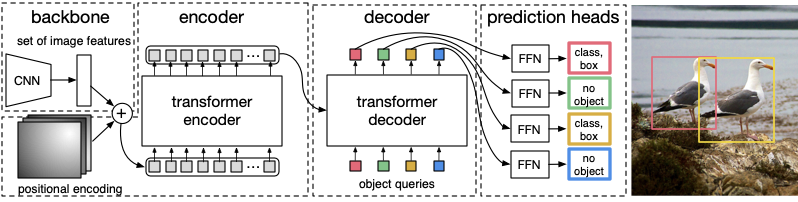

## 3. Import save file of DETR

In [5]:
detr = DETRdemo(num_classes=91)
state_dict = torch.hub.load_state_dict_from_url(
    url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
    map_location='cpu', check_hash=True)
detr.load_state_dict(state_dict)
detr.eval();

In [6]:
detr.transformer

Transformer(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): 

## 4. Preprocessing

> 위에서 불러들인 모델은 80개의 class를 가진 COCO dataset을 이용해 학습됐습니다.  
모델의 구축은 91 classes를 기준으로 했으며, 11개의 class가 누락된 dataset이라 'N/A'를 포함해 91 length의 class를 정의해줍니다.

In [7]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

> DETR은 standard ImageNet normalization을 사용하며, relative image coordinates인 [$x_{center}, y_{center}, w, h$] format을 사용합니다.  
이 때 좌표가 image size에 비례하는 0과 1사이의 값이기 때문에 시각화를 위해 다시 [$x_0, y_0, x_1, y_1] format의 좌표로 바꿔주어야 합니다.

In [8]:
# standard PyTorch mean-std input image normalization
# 1. 이미지의 높이와 너비 중 작은 사이즈가 800으로 고정됩니다.
# 2. Tensor에 맞게끔 [w,h] format이 [h,w] format으로 변합니다.
# 3. dataset의 mean, std를 이용해 정규화가 진행됩니다. (값이 -3과 3사이에 대부분 분포합니다)
transform= T.Compose([
    T.Resize(800), # * 이유.
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # dataset을 확인하면 된다
])

# output bounding box 후처리
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

## 4. Implement Detecting

In [8]:
def detect(im, model, transform):
    
    # input image를 정규화해줍니다. (batch-size : 1)
    img = transform(im).unsqueeze(0)
    
    # demo의 경우 aspect ratio를 0.5와 2사이만 지원합니다.
    # 이 범위 밖의 이미지를 사용하고 싶다면 maximum size을 1333이하로 rescaling해야 합니다.
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600
    
    # model을 통과시킵니다. 
    outputs = model(img)
    
    # 70 % 이상의 정확도를 가진 예측만 남깁니다.
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7
    
    # 0과 1사이의 boxes 값을 image scale로 확대합니다.
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled



In [12]:
url = 'https://news.imaeil.com/inc/photos/2020/11/02/2020110216374231552_l.jpg'
im = Image.open(requests.get(url, stream=True).raw)

In [10]:
import time
start = time.time()

scores, boxes = detect(im, detr, transform)

print("Inference time :", round(time.time()-start, 3), 'sec')

Inference time : 1.239 sec


## 5. Visualize

In [11]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

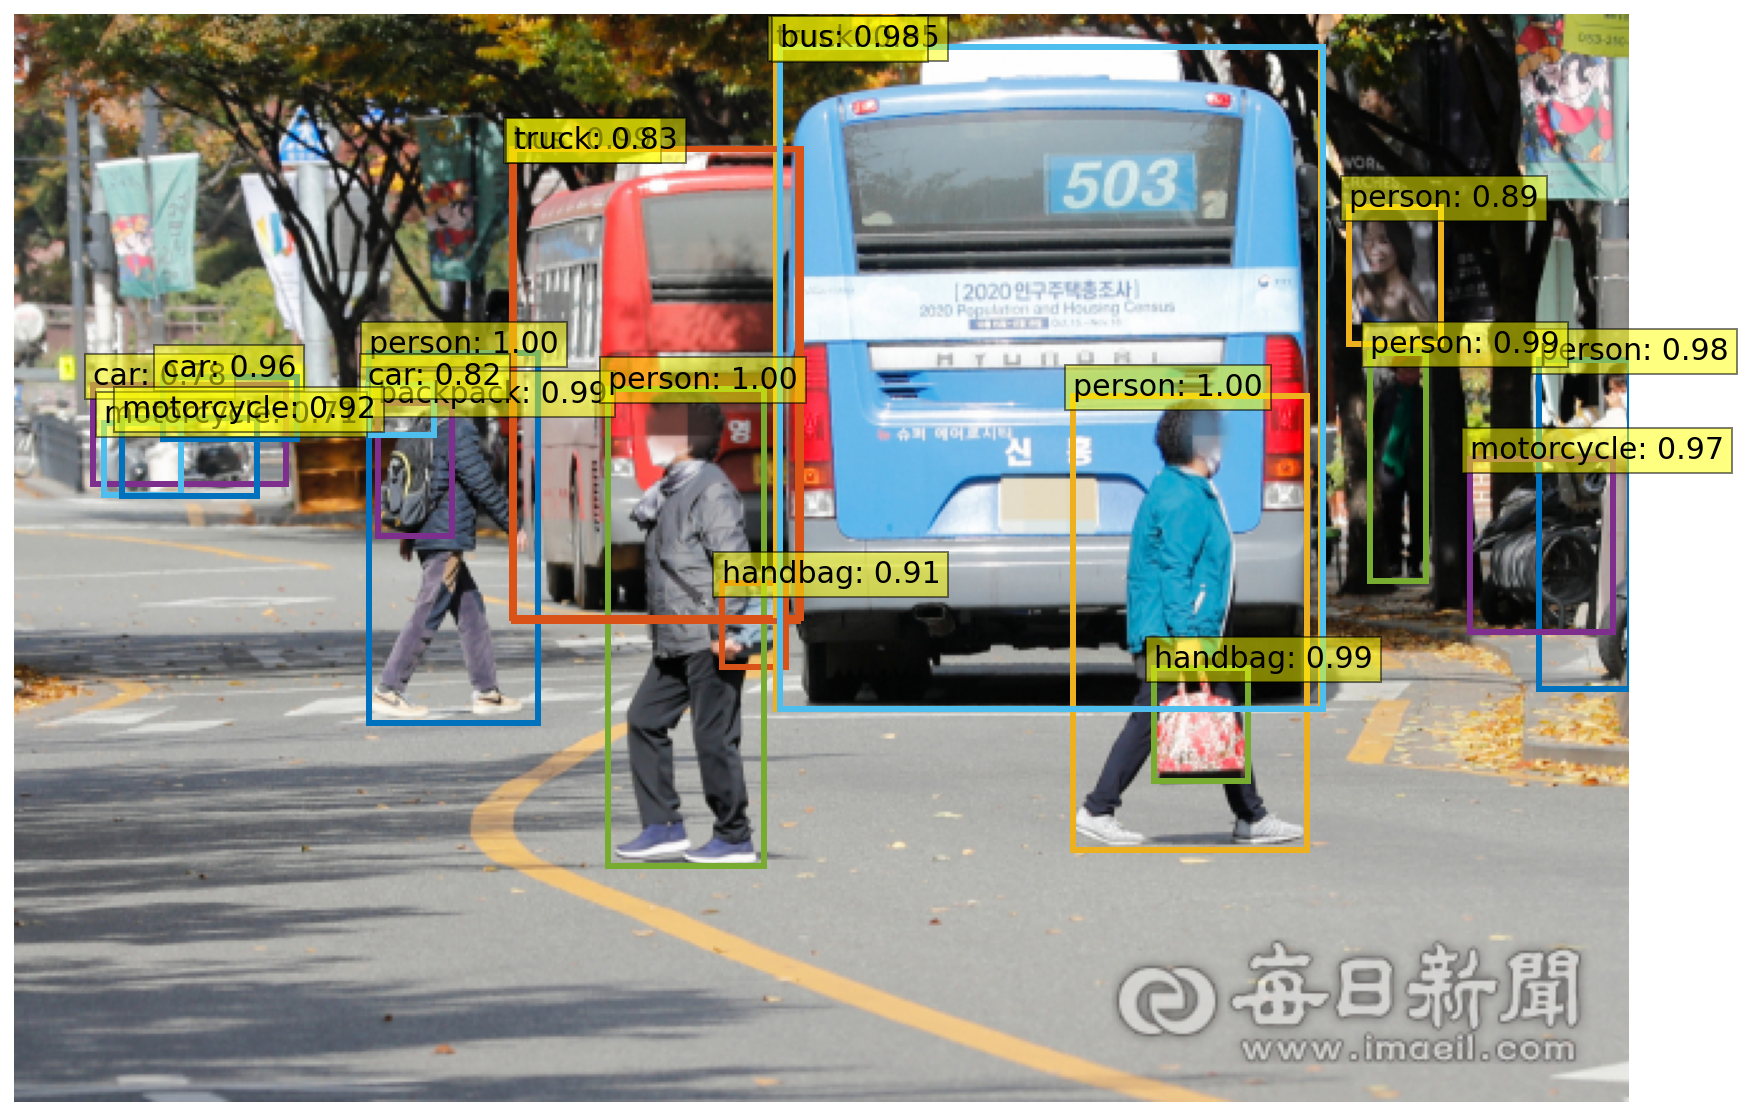

In [12]:
plot_results(im, scores, boxes)

# Attention map 시각화

## 모델 load & Preprocessing

In [13]:
# !pip install ipywidgets

In [9]:
import ipywidgets as widgets
from IPython.display import display, clear_output

In [10]:
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
model.eval();

Using cache found in /home/jrkim/.cache/torch/hub/facebookresearch_detr_master


> 전처리

In [13]:
# 정규화 + 사이즈 변경 + 텐서 전환
img = transform(im).unsqueeze(0)

# 모델 통과
outputs = model(img)

# 0.9 이상의 정확도를 보이는 bounding box만 남긴다.
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.9

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

## encoder-decoder multi-head attention weights 시각화

> 여기서는 decoder의 마지막 layer에 대한 attention weights를 시각화한다.  
decoder의 마지막 layer를 사용하기 때문에 모델이 specific한 bounding box와 class를 예측하는 과정에서  
이미지의 어떤 부분을 제일 참고했는 지 알 수 있다.

In [14]:
# up-values를 통해 output을 저장하는 리스트
conv_features, enc_attn_weights, dec_attn_weights = [], [], []

# 모델을 통과시킬 때 값을 저장할 수 있게끔.
hooks = [
    model.backbone[-2].register_forward_hook(
        lambda self, input, output: conv_features.append(output)
    ),
    model.transformer.encoder.layers[-1].self_attn.register_forward_hook( 
        lambda self, input, output: enc_attn_weights.append(output[1]) # encoder : 여섯 개의 layer 중 last lyaer
    ),
    model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
        lambda self, input, output: dec_attn_weights.append(output[1]) # decoder : 여섯 개의 layer 중 last layer
    ),
]

In [15]:
# 모델 순전파
outputs = model(img)

In [16]:
# hook 제거
for hook in hooks:
    hook.remove()

In [108]:
# Layer 간에 가중치는 공유하기 때문에 하나만 사용해도 된다. (이미 위 hook에서 마지막 layer에 대해서만 저장하긴 했다.)
conv_features = conv_features[0]
enc_attn_weights = enc_attn_weights[0]
dec_attn_weights = dec_attn_weights[0]

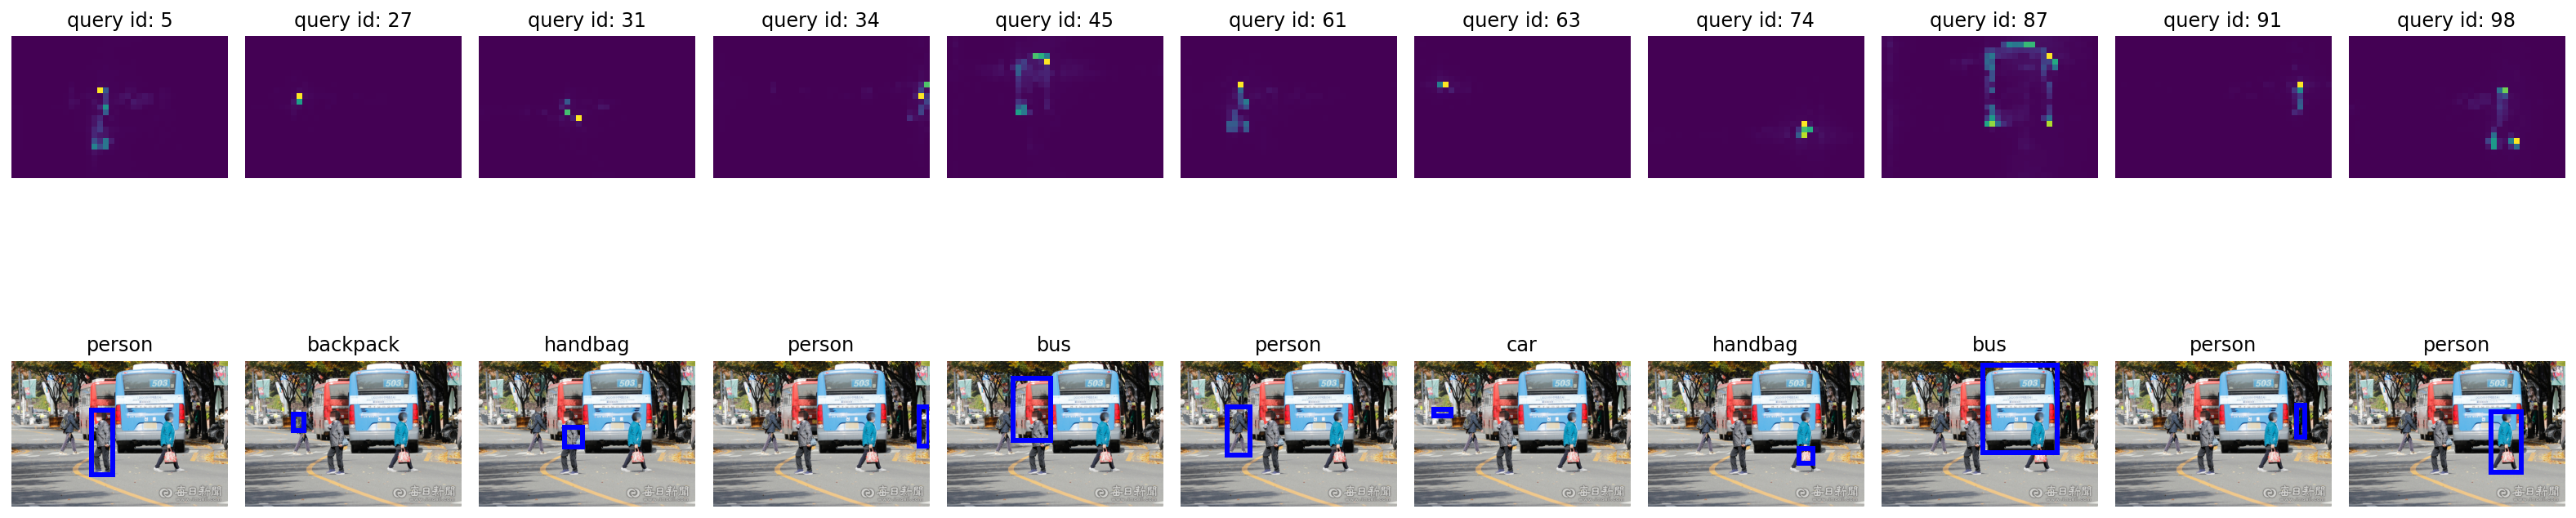

In [109]:
# feature map의 shape 
h, w = conv_features['0'].tensors.shape[-2:]

fig, axs = plt.subplots(ncols=len(bboxes_scaled), nrows=2, figsize=(22, 7))
colors = COLORS * 100
for idx, ax_i, (xmin, ymin, xmax, ymax) in zip(keep.nonzero(), axs.T, bboxes_scaled):
    ax = ax_i[0]
    ax.imshow(dec_attn_weights[0, idx].view(h, w))
    ax.axis('off')
    ax.set_title(f'query id: {idx.item()}')
    ax = ax_i[1]
    ax.imshow(im)
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                               fill=False, color='blue', linewidth=3))
    ax.axis('off')
    ax.set_title(CLASSES[probas[idx].argmax()])
fig.tight_layout()

## encoder self-attention weights 시각화

> 여기선 모델의 self-attention을 시각화한다.  
- 모델이 objects를 어떻게 인코딩 했는 지 확인할 수 있다.  
- 특히, encoder가 이미 객체 분리 과정에 사용한 attention response maps을 볼 수 있다.



In [114]:
# Feature map(CNN backbone)과 Encoder attention weight(Transformer Encoder)의 차원을 보자.
f_map = conv_features['0']
print("Encoder attention:      ", enc_attn_weights[0].shape)
print("Feature map:            ", f_map.tensors.shape)

Encoder attention:       torch.Size([950, 950])
Feature map:             torch.Size([1, 2048, 25, 38])


In [121]:
# get HxW shape
shape = f_map.tensors.shape[-2:]
# more interpretable shape으로 reshape해준다. (encoder token의 길이는 HxW 이기 때문에 아래와 같이 reshape한다.)
sattn = enc_attn_weights[0].reshape(shape + shape)
print("Reshaped self-attention:", sattn.shape)

Reshaped self-attention: torch.Size([25, 38, 25, 38])


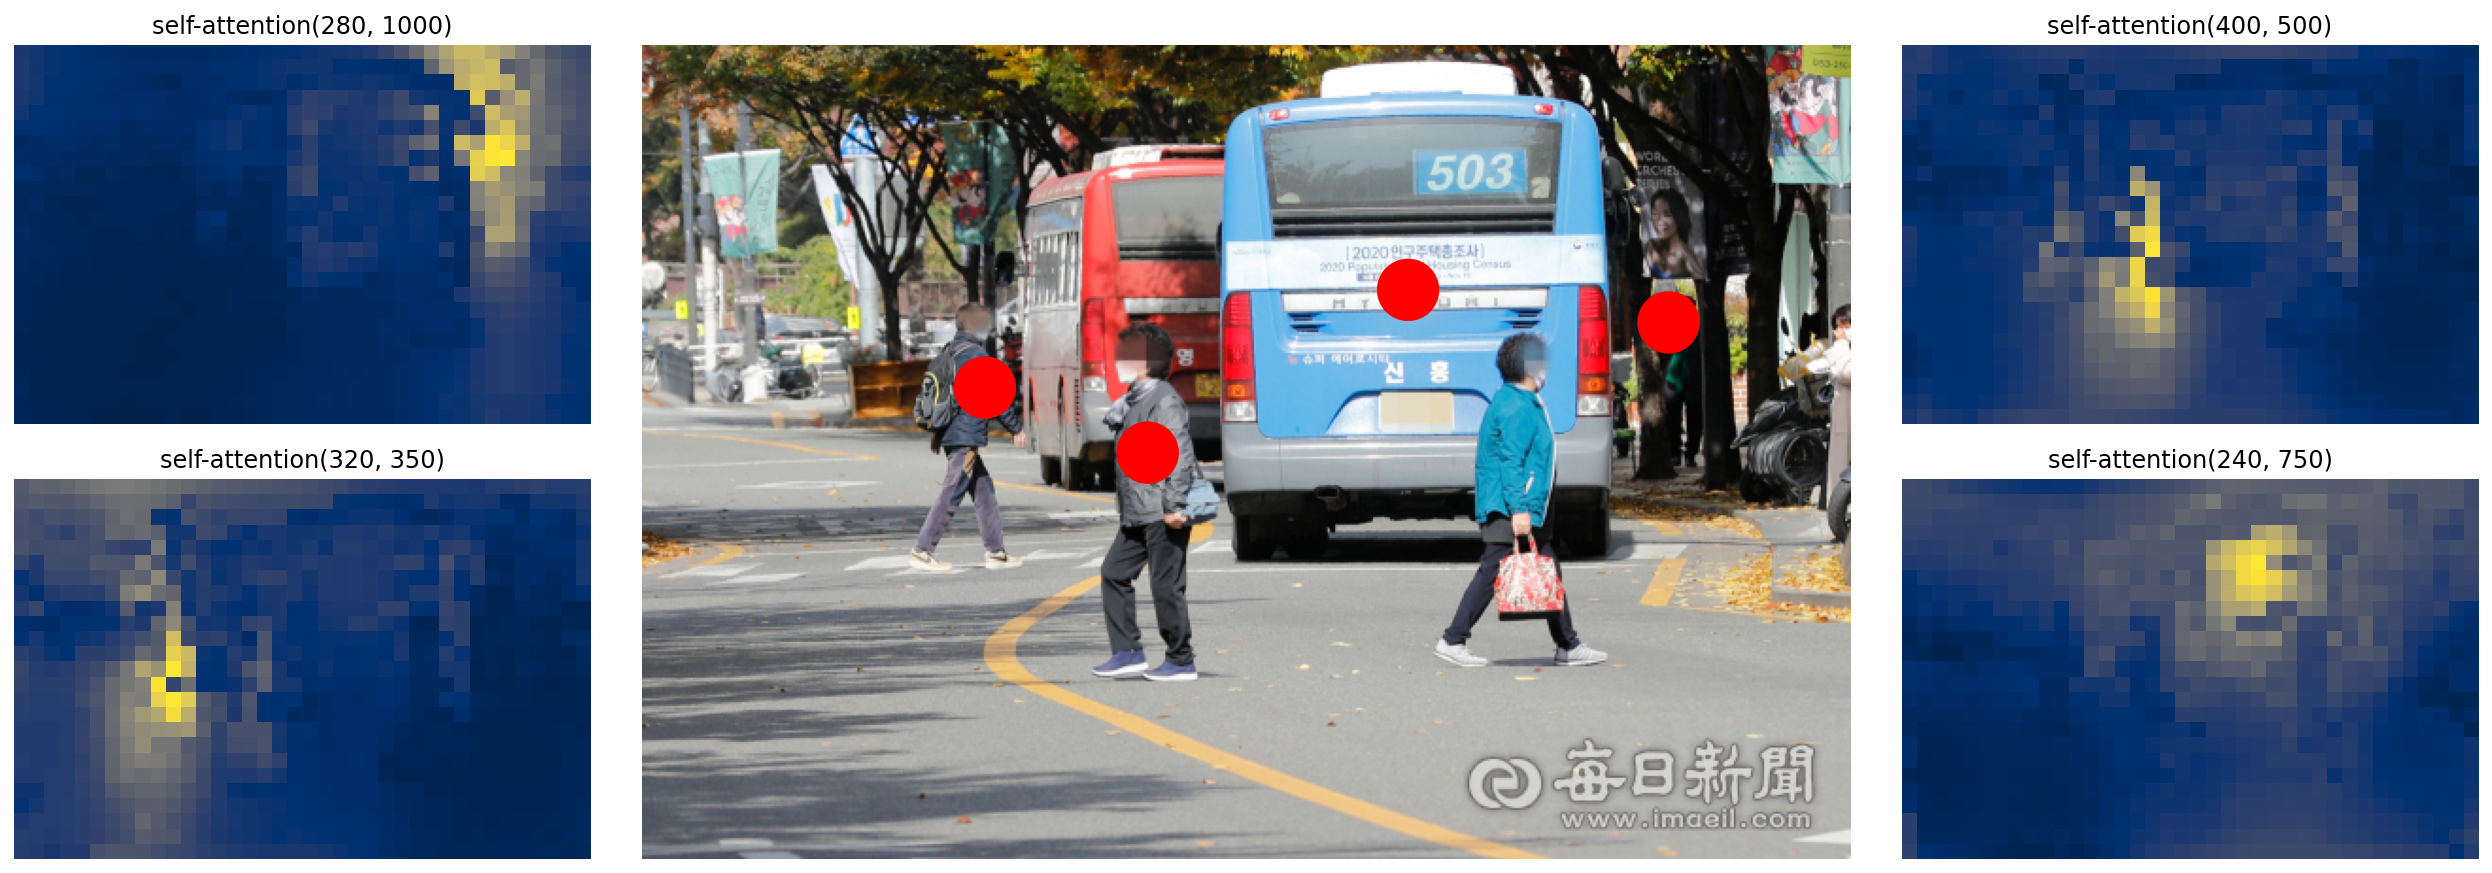

In [124]:
# downsampling factor for the CNN(32 for DETR, 16 for DETR DC5)
fact = 32

# 시각화를 위해 4개의 reference points를 고른다. ()
idxs = [(280, 1000), (320, 350), (400, 500), (240, 750),]

# canvas 생성
fig = plt.figure(constrained_layout=True, figsize=(25 * 0.7, 8.5 * 0.7))
# and we add one plot per reference point
gs = fig.add_gridspec(2, 4)
axs = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[1, 0]),
    fig.add_subplot(gs[0, -1]),
    fig.add_subplot(gs[1, -1]),
]

# reference point 마다 self-attention plot.
# for that point
for idx_o, ax in zip(idxs, axs):
    idx = (idx_o[0] // fact, idx_o[1] // fact)
    ax.imshow(sattn[..., idx[0], idx[1]], cmap='cividis', interpolation='nearest')
    ax.axis('off')
    ax.set_title(f'self-attention{idx_o}')

# central image를 더해준다.
# reference points : 빨간 원
fcenter_ax = fig.add_subplot(gs[:, 1:-1])
fcenter_ax.imshow(im)
for (y, x) in idxs:
    scale = im.height / img.shape[-2]
    x = ((x // fact) + 0.5) * fact
    y = ((y // fact) + 0.5) * fact
    fcenter_ax.add_patch(plt.Circle((x * scale, y * scale), fact // 2, color='r'))
    fcenter_ax.axis('off')

### Example in paper

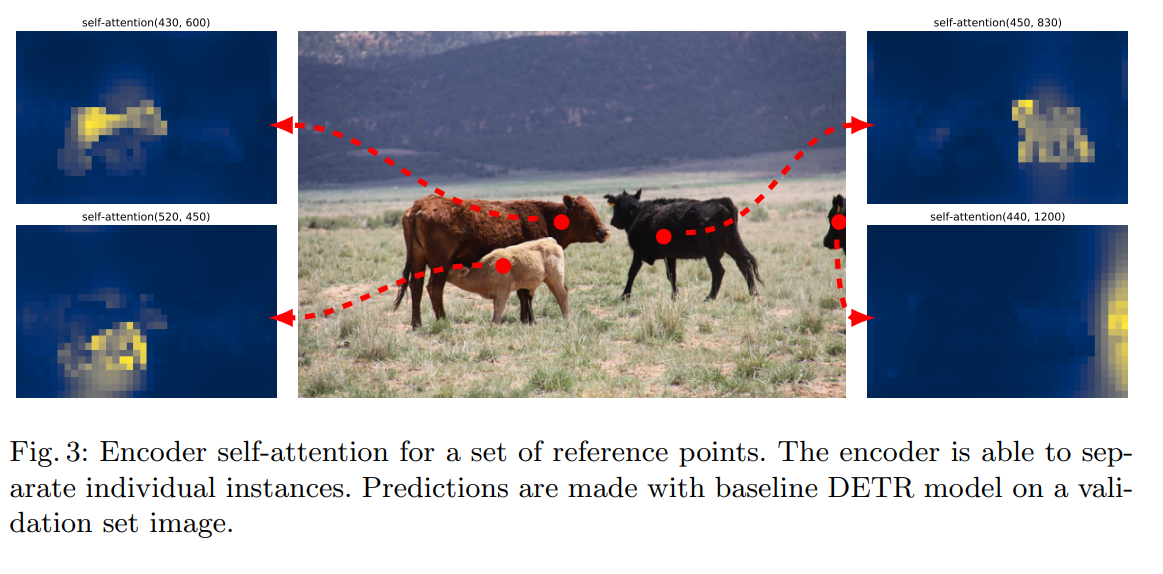

## Visualizer

In [131]:
# up-values를 통해 output을 저장하는 리스트
conv_features, enc_attn_weights, dec_attn_weights = [], [], []

In [135]:
import math

from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import ipywidgets as widgets
from IPython.display import display, clear_output

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

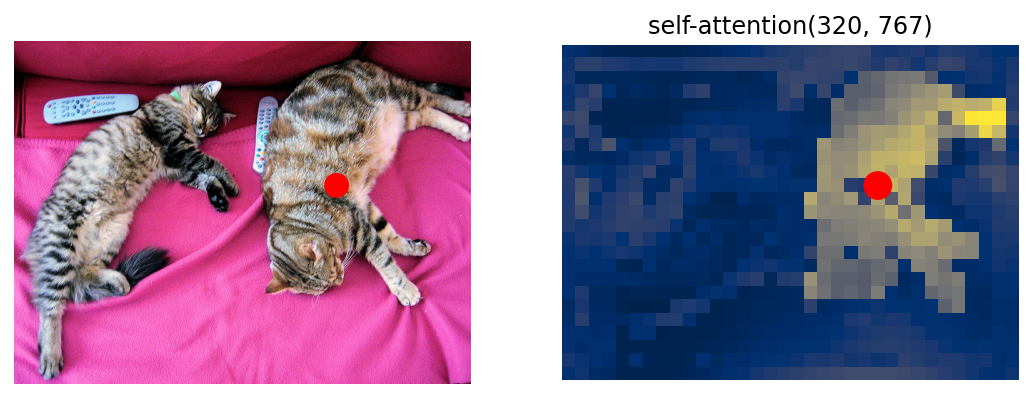

In [136]:
w = AttentionVisualizer(model, transform)
w.run()

# 코드 차원 파헤치기

In [214]:
class DETRdemo_analyize(DETRdemo):
    """
    개인 분석용입니다.
    """
    
    def __init__(self, num_classes):
        
        # nn.Module을 initialize 해줍니다.
        super().__init__(num_classes=num_classes)
        
    def forward(self, inputs):
        
        # Resnet-50에서 average pooling layer까지 순전파시킵니다. 
        # resnet은 최초의 convolution - batch norm - relu - maxpool을 거친 후, 
        # conv-batch norm을 주 구성요소로 하는 Bottleneck layer을 굉장히 많이 통과시킵니다.
        print('inputs : ', inputs.shape)
        x = self.backbone.conv1(inputs)
        print('conv1 : ', x.shape)
        x = self.backbone.bn1(x)
        print('bn1 : ', x.shape)
        x = self.backbone.relu(x)
        print('relu1 : ', x.shape)
        x = self.backbone.maxpool(x)
        print('maxpool : ', x.shape)
        
        x = self.backbone.layer1(x)
        print('layer1 : ', x.shape)
        x = self.backbone.layer2(x)
        print('layer2 : ', x.shape)
        x = self.backbone.layer3(x)
        print('layer3 : ', x.shape)
        x = self.backbone.layer4(x)
        print('layer4 : ', x.shape)
        
        # *이 때, layer4에는 avg layer가
        
        # 2048차원을 256차원의 feature planes으로 만들어줍니다.
        h = self.conv(x)
        print('conv(2048 -> 256) : ', h.shape)
        
        # positional encoding을 구성합니다.
        
        H, W = h.shape[-2:] # * ( )차원입니다.
        print('H, W : ', H, W)
        
        print('col_embed[:W]: ', self.col_embed[:W].shape)
        print('col_embed[:W].unsqueeze(0): ', self.col_embed[:W].unsqueeze(0).shape)
        print('col_embed[:W].unsqueeze(0).repeat(H, 1, 1): ', self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1).shape)
        
        print('row_embed[:H]: ', self.row_embed[:H].shape)
        print('row_embed[:H].unsqueeze(1): ', self.row_embed[:H].unsqueeze(1).shape)
        print('row_embed[:H].unsqueeze(1).repeat(1, W, 1) : ', self.row_embed[:H].unsqueeze(1).repeat(1, W, 1).shape)
        
        pos=torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)
        print('spatial positional encodings(pos)(not flatten): ', torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).shape)
        print('spatial positional encodings(pos).flatten(0,1)): ', torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0,1).shape)
        print('spatial positional encodings(pos).flatten(0,1).unsqueeze(1))', pos.shape)
        
        # transformer를 순전파시킵니다.
        print('h : ', h.shape)
        print('h.flatten(2) : ', h.flatten(2).shape)
        print('h.flatten(2).permute(2,0,1) : ', h.flatten(2).permute(2, 0, 1).shape)
        
        print('output positioanl encodings(objectj queries) : ', self.query_pos.shape)
        print('output positioanl encodings(objectj queries)(unsqueeze(1)) : ', self.query_pos.unsqueeze(1).shape)
        
        print('transformer input1 : ', (pos+0.1*h.flatten(2).permute(2, 0, 1)).shape)
        print('transformer input2(object queries) : ', self.query_pos.unsqueeze(1).shape)
        h = self.transformer(pos+0.1*h.flatten(2).permute(2, 0, 1),
                            self.query_pos.unsqueeze(1)).transpose(0,1)
        print('transformer output : ', h.shape)
        
        # 최종적으로, transformer output을 class label과 bounding boxes로 사영시킵니다.
        
    
        print('pred_logits : ', self.linear_class(h).shape)
        print('pred_bboxes : ', self.linear_bbox(h).sigmoid().shape)
        return {'pred_logits': self.linear_class(h),
                'pred_boxes': self.linear_bbox(h).sigmoid()}
        
        

In [215]:
detr= DETRdemo_analyize(num_classes=91)
detr.load_state_dict(state_dict)
detr.eval();

### 편의상 이미지 사이즈는 640 x 480 으로 수정하자.
> 그러면, transform 결과 input은 height는 800으로, width는 1066으로 변합니다.


In [216]:
# im=im.resize((640, 480))

In [217]:
detr.col_embed

Parameter containing:
tensor([[ 0.9219,  0.0964,  0.7983,  ...,  0.9194, -0.0169,  0.6523],
        [ 0.2247,  0.2192,  0.6538,  ...,  0.0020,  0.3018,  0.2683],
        [ 0.6938,  0.4739,  0.2578,  ...,  0.3005,  0.3860,  0.6406],
        ...,
        [ 0.7559,  0.9976,  0.9482,  ...,  0.3545,  0.1346,  0.9946],
        [ 0.2146,  0.2820,  0.2255,  ...,  0.2959,  0.8237,  0.9526],
        [ 0.6606,  0.9424,  0.6929,  ...,  0.9565,  0.3560,  0.5161]],
       requires_grad=True)

In [218]:
import time
start = time.time()

scores, boxes = detect(im, detr, transform)

print("Inference time :", round(time.time()-start, 3), 'sec')

inputs :  torch.Size([1, 3, 800, 1066])
conv1 :  torch.Size([1, 64, 400, 533])
bn1 :  torch.Size([1, 64, 400, 533])
relu1 :  torch.Size([1, 64, 400, 533])
maxpool :  torch.Size([1, 64, 200, 267])
layer1 :  torch.Size([1, 256, 200, 267])
layer2 :  torch.Size([1, 512, 100, 134])
layer3 :  torch.Size([1, 1024, 50, 67])
layer4 :  torch.Size([1, 2048, 25, 34])
conv(2048 -> 256) :  torch.Size([1, 256, 25, 34])
H, W :  25 34
col_embed[:W]:  torch.Size([34, 128])
col_embed[:W].unsqueeze(0):  torch.Size([1, 34, 128])
col_embed[:W].unsqueeze(0).repeat(H, 1, 1):  torch.Size([25, 34, 128])
row_embed[:H]:  torch.Size([25, 128])
row_embed[:H].unsqueeze(1):  torch.Size([25, 1, 128])
row_embed[:H].unsqueeze(1).repeat(1, W, 1) :  torch.Size([25, 34, 128])
spatial positional encodings(pos)(not flatten):  torch.Size([25, 34, 256])
spatial positional encodings(pos).flatten(0,1)):  torch.Size([850, 256])
spatial positional encodings(pos).flatten(0,1).unsqueeze(1)) torch.Size([850, 1, 256])
h :  torch.Size(

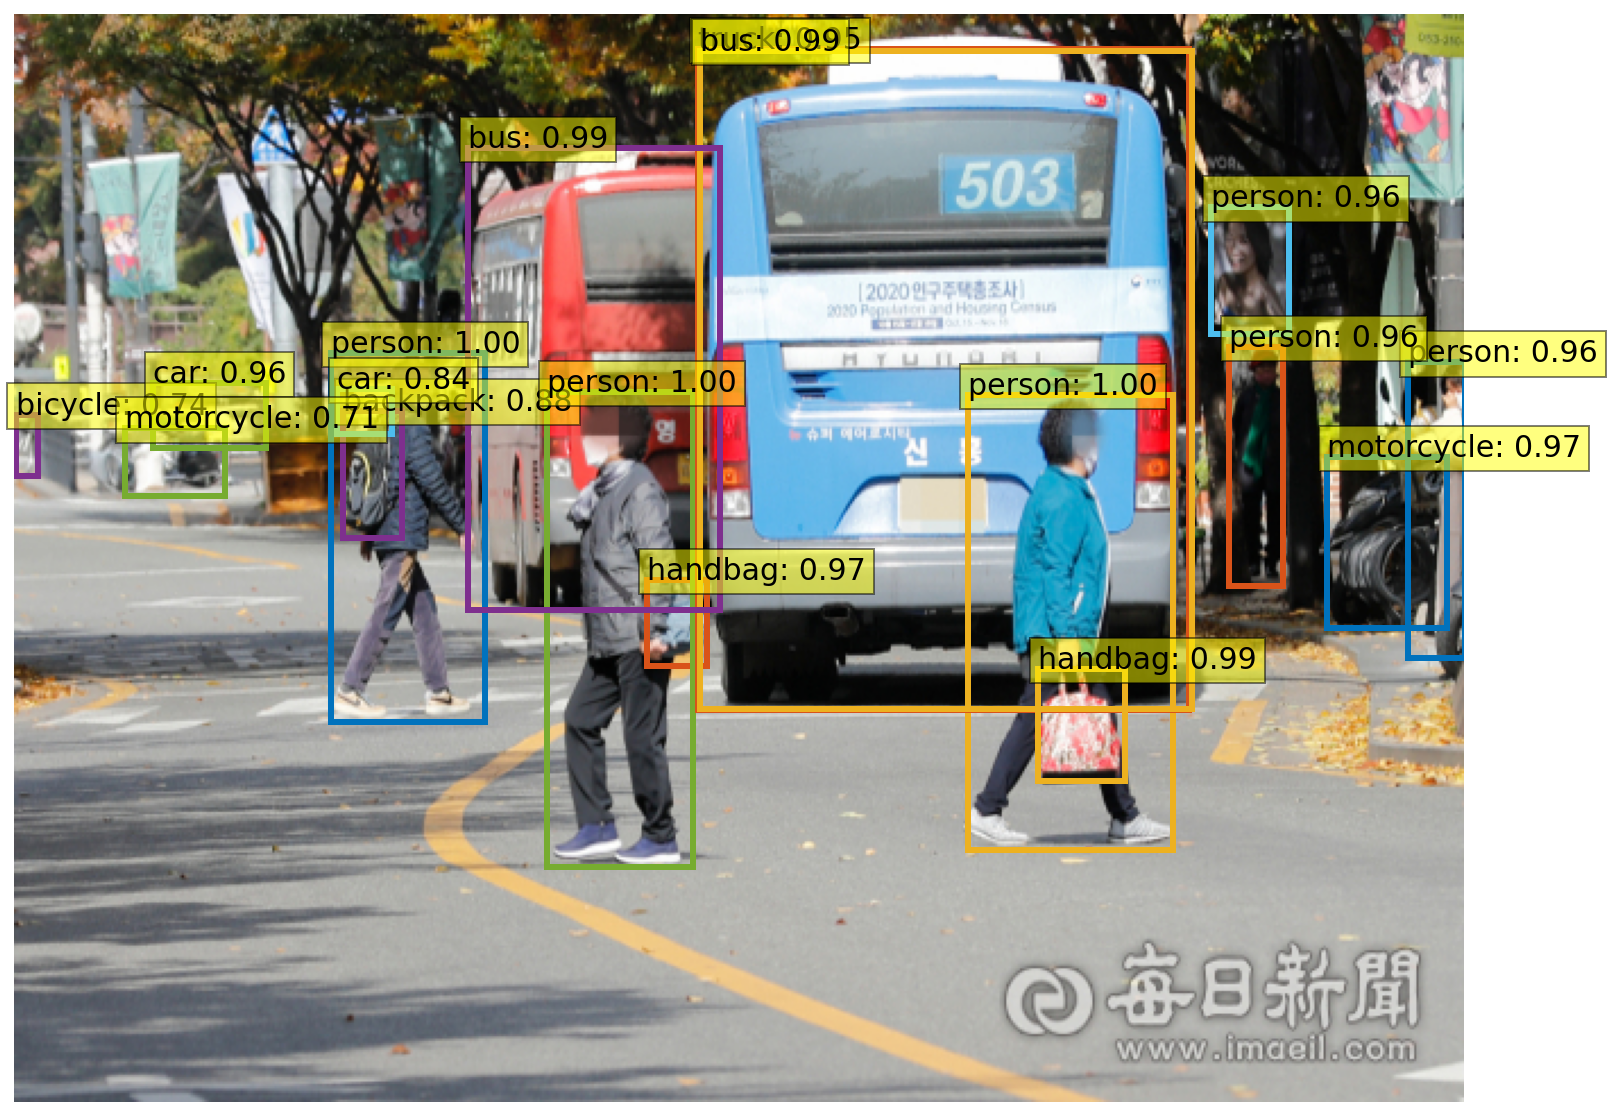

In [219]:
plot_results(im, scores, boxes)

# 명령어 정리(낙서장)



https://pytorch.org/docs/stable/generated/torch.flatten.html#torch.flatten  
https://pytorch.org/docs/stable/generated/torch.Tensor.repeat.html  
https://pytorch.org/docs/stable/generated/torch.unsqueeze.html 


https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html  

In [199]:
# tensor.unsqueeze(0) : (x,h) --> (0, x, h)
# tensor.unsqueeze(1) : (x,h) --> (x, 1, h)
# 즉, 차원 확대
    

In [198]:
x=torch.tensor([[10,30,50,50,30],[100,200,300,400,500],[5,10,20,40,60]])
print(x.shape)
print(x.unsqueeze(0).shape)
print(x.unsqueeze(1).shape)

torch.Size([3, 5])
torch.Size([1, 3, 5])
torch.Size([3, 1, 5])


In [ ]:
# tensor.repeat((H, 1, 1)) : 인자로 주어진 값만큼 각 차원에서 tensor를 반복


In [188]:
(torch.tensor([1, 2, 3]).repeat(4,2))

tensor([[1, 2, 3, 1, 2, 3],
        [1, 2, 3, 1, 2, 3],
        [1, 2, 3, 1, 2, 3],
        [1, 2, 3, 1, 2, 3]])

In [205]:
print((torch.tensor([1, 2, 3]).repeat(4,2,3)).shape)
torch.tensor([1, 2, 3]).repeat(4,2,3)

torch.Size([4, 2, 9])


tensor([[[1, 2, 3, 1, 2, 3, 1, 2, 3],
         [1, 2, 3, 1, 2, 3, 1, 2, 3]],

        [[1, 2, 3, 1, 2, 3, 1, 2, 3],
         [1, 2, 3, 1, 2, 3, 1, 2, 3]],

        [[1, 2, 3, 1, 2, 3, 1, 2, 3],
         [1, 2, 3, 1, 2, 3, 1, 2, 3]],

        [[1, 2, 3, 1, 2, 3, 1, 2, 3],
         [1, 2, 3, 1, 2, 3, 1, 2, 3]]])

In [231]:
x=torch.tensor([[[1,2],[3,4],[5,6]],[[1,2],[3,4],[5,6]],[[1,2],[3,4],[5,6]],[[1,2],[3,4],[5,6]]])
print(x.shape)
print(x.flatten(0,1).shape)
print(x.flatten(1,2).shape)
# 즉, tensor.flatten(flatten 시작 차원, flatten 끝 차원)

torch.Size([4, 3, 2])
torch.Size([12, 2])
torch.Size([4, 6])
